<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fetch-data" data-toc-modified-id="Fetch-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fetch data</a></span></li><li><span><a href="#Structure-learning" data-toc-modified-id="Structure-learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Structure learning</a></span></li></ul></div>

In [1]:
import os
import json
import pandas as pd
import numpy as np

from  pomegranate  import BayesianNetwork
import pygraphviz
import tempfile
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

# Fetch data

Assemble the processed/harmonized datasets for analysis. We use the configuration file to determine which datasets to use.

In [2]:
start_time = time()
with open("../configuration.json", 'rt') as infile:
    config = json.load(infile)
    
sources = [os.path.join('..', config['paths']['output'], d['name'], 'data.csv') for d in config['sources']]

# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Row count          : {}".format(len(df)))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))

Sources            : 3
Row count          : 53443
Geographies        : 294
Indicators         : 16
Temporal coverage  : 1960 -> 2018
Null values        : 0

Loaded data in 0.15 sec.


In [3]:
# Indicators being used
df['Indicator Name'].unique()

array(['Population, total',
       'Renewable internal freshwater resources per capita (cubic meters)',
       'GINI index (World Bank estimate)',
       'Battle-related deaths (number of people)',
       'GDP per capita, PPP (current international $)',
       'Refugee population by country or territory of asylum',
       'Refugee population by country or territory of origin',
       'Refugees (incl. refugee-like situations)', 'Returnees',
       'Internally displaced persons', 'Returned IDPs',
       'Others of concern', 'Asylum-seekers', 'Stateless',
       'ACLED total number of violent incidents annually.',
       'ACLED number of fatalities annually from violence.'], dtype=object)

# Structure learning

Now we aim to learn the causual network of these development indicators. The causal network is a DAG (directed acyclic graph) that aims at showing relationships between two indicators. This is expensive to learn, particularly if there are greater than 25 indicators. 

Additionally `pomegranate` only supports discrete distributions for now. 

In [3]:
# Data transformations for structure learning

# Organize the indicators in "long form"
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Discretization scheme

# TODO: This is primitive, consider:
# - (min-max) after looking at the distributions
# - https://arxiv.org/pdf/1512.02406.pdf 

def discretization(x, BINS=10):
    """ Discretize indicators """
    return pd.cut(x, BINS, labels=False)
    

X = data.apply(discretization, axis=1)

X.head()

Indicator Code     ACLED.COUNT  ACLED.FATALITIES  ER.H2O.INTR.PC  \
Country Code year                                                  
ABW          1960          NaN               NaN             NaN   
             1961          NaN               NaN             NaN   
             1962          NaN               NaN             NaN   
             1963          NaN               NaN             NaN   
             1964          NaN               NaN             NaN   

Indicator Code     NY.GDP.PCAP.PP.CD  SI.POV.GINI  SM.POP.REFG  \
Country Code year                                                
ABW          1960                NaN          NaN          NaN   
             1961                NaN          NaN          NaN   
             1962                NaN          NaN          NaN   
             1963                NaN          NaN          NaN   
             1964                NaN          NaN          NaN   

Indicator Code     SM.POP.REFG.OR  SP.POP.TOTL  UNHCR.OUT.AS  UNHCR.OUT.IDP  \
Country Code year                                                             
ABW          1960             NaN          4.0           NaN            NaN   
             1961             NaN          4.0           NaN            NaN   
             1962             NaN          4.0           NaN            NaN   
             1963             NaN          4.0           NaN            NaN   
             1964             NaN          4.0           NaN            NaN   

Indicator Code     UNHCR.OUT.OOC  UNHCR.OUT.REF  UNHCR.OUT.RET  \
Country Code year                                                
ABW          1960            NaN            NaN            NaN   
             1961            NaN            NaN            NaN   
             1962            NaN            NaN            NaN   
             1963            NaN            NaN            NaN   
             1964            NaN            NaN            NaN   

Indicator Code     UNHCR.OUT.RETIDP  UNHCR.OUT.STLS  VC.BTL.DETH  
Country Code year                                                 
ABW          1960               NaN             NaN          NaN  
             1961               NaN             NaN          NaN  
             1962               NaN             NaN          NaN  
             1963               NaN             NaN          NaN  
             1964               NaN             NaN          NaN

In [7]:
# Model learning
start_time = time()
model = BayesianNetwork.from_samples(X, 
                                     algorithm='greedy', 
                                     state_names=X.columns, 
                                     #max_parents=2,
                                     n_jobs=4)
print("Structure learning in {:3.2f} sec.".format(time() - start_time))

Structure learning in 169.28 sec.


In [20]:
# Model plot
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

def plot_model(model):
    """ Helper function - since I can't get the built in methods to work """
    
    G = pygraphviz.AGraph(directed=True)
    
    G.node_attr['fontsize'] = '20'
    #G.node_attr['fontcolor']='#FFFFFF'
    
    for state in model.states:
        G.add_node(state.name, color='blue', shape='circle')

    for parent, child in model.edges:
        G.add_edge(parent.name, child.name, color='blue')

    """
    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = mpl_image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')
        plt.savefig("test.png")
    """
    with open("test.png", 'wb') as tf:
        G.draw(tf, format='png', prog='dot')

def plot_networkx(Q, edge_label=None, filename=None):
    G = pygraphviz.AGraph(directed=True)

    for state in Q.nodes():
        G.add_node(state, color='red')

    for parent, child, data in Q.edges(data=True):
        if edge_label:
            G.add_edge(parent, child, label=data[edge_label])
        else:
            G.add_edge(parent, child)


    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = matplotlib.image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')
        

In [21]:
plot_model(model)

In [123]:
# Constrained version of structure learning 
import networkx

def column_index(lbl, l):
    try:
        return l.index(lbl)
    except ValueError:
        print("{} is not in list.".format(lbl))
        pass


a = networkx.DiGraph()
DISPLACEMENT = ("VC.IDP.NWCV", "SM.POP.REFG.OR")
ECON_DRIVERS = ("SI.POV.GINI", "NY.GDP.PCAP.PP.CD")
#EDU_DRIVERS = tuple(("SE.PRM.CMPT.ZS",))
CONF_DRIVERS = tuple(("VC.BTL.DETH",))
SOCIAL_DRIVERS = ("ER.H2O.INTR.PC", "per_sa_allsa.cov_pop_tot" )

columns = X.columns.tolist()

# Constraint graph only takes integers
DISPLACEMENT_IDX = tuple(map(lambda p: column_index(p, columns), DISPLACEMENT))
ECON_DRIVERS_IDX = tuple(map(lambda p: column_index(p, columns), ECON_DRIVERS))
#EDU_DRIVERS_IDX = tuple(map(lambda p: column_index(p, columns), EDU_DRIVERS))
CONF_DRIVERS_IDX = tuple(map(lambda p: column_index(p, columns), CONF_DRIVERS))
SOCIAL_DRIVERS_IDX = tuple(map(lambda p: column_index(p, columns), SOCIAL_DRIVERS))


a.add_edge(ECON_DRIVERS_IDX, DISPLACEMENT_IDX)
#a.add_edge(EDU__DRIVERS_IDX, DISPLACEMENT_IDX)
a.add_edge(CONF_DRIVERS_IDX, DISPLACEMENT_IDX)
a.add_edge(SOCIAL_DRIVERS_IDX, DISPLACEMENT_IDX)


start_time = time()
model = BayesianNetwork.from_samples(X, 
                                     algorithm='exact',
                                     state_names=X.columns,
                                     constraint_graph=a)
print("Structure learning (constrained) in {:3.2f} sec.".format(time() - start_time))


Structure learning (constrained) in 16.65 sec.


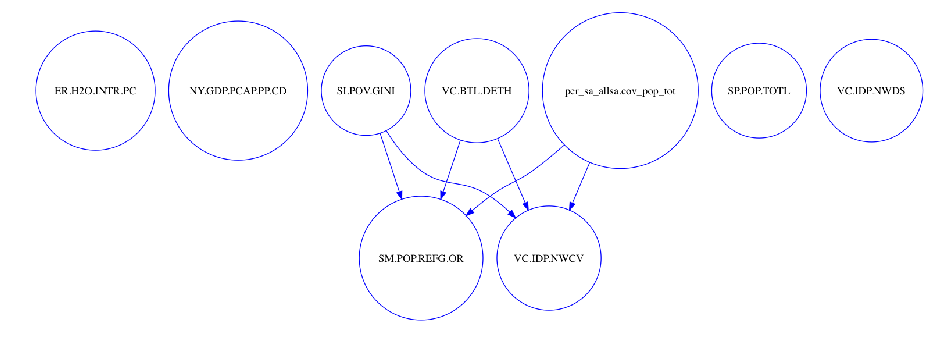

In [125]:
plot_model(model)